# Google colab: neural networkk

In [23]:
# Clone the repository
!git clone https://github.com/fridamarieLJ/Materials-Design-with-Machine-Learning.git

# Navigate to the repository
%cd 'Materials-Design-with-Machine-Learning'

# List files in the repository
!ls

Cloning into 'Materials-Design-with-Machine-Learning'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 216 (delta 40), reused 35 (delta 17), pack-reused 148 (from 1)
Receiving objects: 100% (216/216), 3.24 MiB | 12.67 MiB/s, done.
Resolving deltas: 100% (96/96), done.
/content/Materials-Design-with-Machine-Learning/Materials-Design-with-Machine-Learning
Albert		 neural_network.ipynb  project_dataload.py	       __pycache__
Fingerprints.py  new_notebook.ipynb    project_gaussian.py	       Sinematrix.py
GP.py		 PCA_decomposition.py  project_main.ipynb	       SOAP.py
LoadData.py	 project_data	       project_main_test_albert.ipynb


In [24]:
# Import dependencies
!pip install ase
!pip install dscribe

In [25]:
# import self made functions
from project_dataload import data_load, check_data, summarize_1
from project_gaussian import *
from Fingerprints import Sinemats, Coulombmatrices, Ewaldsummatrices
from PCA_decomposition import *
from GP import GP


In [83]:
# import ml relevant libraries
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt

In [71]:
###Data load and check
data_dir="./project_data/"
train, test = data_load(data_dir)

print('Check train data')
check_data(train)
print('Check test data')
check_data(test)
summary = summarize_1(train, test)
print('Max number of atoms',summary['max_number_of_atoms'])

Check train data
Train data shape: (8000, 4)
     id        formula                                              atoms  \
0  5154         Zr2BO2  (Atom('Zr', [1.6878604657, 0.892285133, 8.1345...   
1   984          Ni2S6  (Atom('Ni', [1.1571403137, 0.934725185, 12.234...   
2  1634  Cd4K2Cl6O6Te2  (Atom('Cd', [2.7840261751, 5.6922402759, 26.71...   
3  1872      Hf4H2N3O2  (Atom('Hf', [0.0, 1.8677827772, 12.2421466347]...   
4  2977         Sc2Te2  (Atom('Te', [0.0003850118, 0.0002469812, 7.461...   

      hform  
0 -2.037877  
1 -0.091020  
2 -1.109751  
3 -1.609142  
4 -0.854593  
Check test data
Train data shape: (4000, 3)
      id     formula                                              atoms
0   8538    HfZrSTe2  (Atom('S', [-1.0327079693, 4.2080182974, 22.81...
1   9052    Nb2P2Te6  (Atom('Nb', [0.3517632032, -0.2042419274, 9.20...
2  10503  Au2InI2Se2  (Atom('Se', [0.2238411856, 0.8131388722, 26.83...
3    611   AuTlO6Sb2  (Atom('Au', [0.0002076097, -0.0001198635, 16.6...
4   

In [72]:
### Implement fingerprint
max_num_atoms = summary['max_number_of_atoms']
cmats = Coulombmatrices(train, max_num_atoms)
y_vals = train['hform']
print('Shape of cmats', cmats.shape)

0
1000
2000
3000
4000
5000
6000
7000
Shape of cmats (8000, 400)


In [73]:
#Splitting data (the part with targets available, i.e. train) in train and test

# Set target and feature vector
X = pd.DataFrame(data = cmats, index=train.id)
y = pd.DataFrame(train['hform'].values, index = train.id)
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))
# Split training data into a training set and a validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=251)
y_test_values = y_test.values  # Extract values as a NumPy array
y_train_values = y_train.values  # Extract values as a NumPy array
print('X_train: {}'.format(X_train.shape))
print('X_test: {}'.format(X_test.shape))
print('y_train: {}'.format(y_train.shape))
print('y_test: {}'.format(y_test.shape))

X: (8000, 400)
y: (8000, 1)
X_train: (6400, 400)
X_test: (1600, 400)
y_train: (6400, 1)
y_test: (1600, 1)


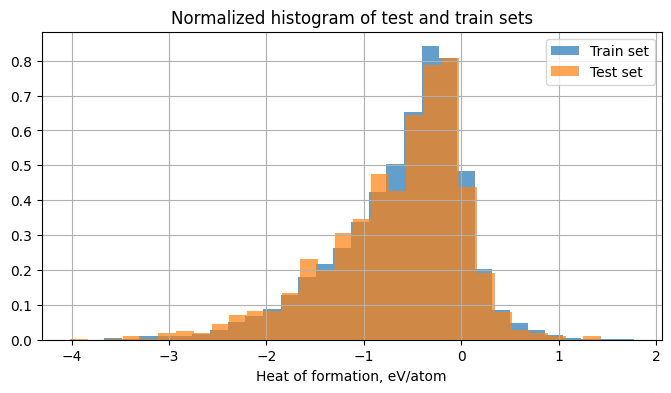

In [125]:
# Visualise data
plt.figure(figsize = (8, 4))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.grid()
plt.title("Normalized histogram of test and train sets")
plt.xlabel("Heat of formation, eV/atom")
plt.legend()
plt.show()

In [126]:
# PC Decomposition
n_PC = 40
X_train_pca, X_test_pca = PCA_decomposition(X_train, X_test, n_PC)
print('Shape X_train_pca', X_train_pca.shape)
print('Shape X_test_pca', X_test_pca.shape)


With 40 PCA components 91.9809% of the variance is explained
X_train: (6400, 400)
X_test: (1600, 400)
Shape X_train_pca (6400, 40)
Shape X_test_pca (1600, 40)


### Below is code from chat gpt

In [132]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_values, dtype=torch.float32)

# Combine features and targets into datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [133]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate the model
input_dim = n_PC  # Number of PCA components
hidden_dim = 124  # Size of hidden layers
output_dim = 1  # Single output for regression
model = SimpleNN(input_dim, hidden_dim, output_dim)


In [134]:
# Loss function
criterion = nn.MSELoss()

# Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [135]:
# Define training and testing functions
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Clear gradients
            y_pred = model(X_batch).squeeze()  # Forward pass
            loss = criterion(y_pred, y_batch)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


def test_model(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch).squeeze()  # Forward pass
            loss = criterion(y_pred, y_batch)  # Compute loss
            total_loss += loss.item()
    MSE = total_loss/len(test_loader)
    print(f"Test Loss: {MSE:.4f}")
    print(f"RMSE Loss: {np.sqrt(MSE):.4f}")

In [136]:
#Train the model
num_epochs = 15
train_model(model, train_loader, criterion, optimizer, num_epochs)


Epoch 1/15, Loss: 0.4826
Epoch 2/15, Loss: 0.4608
Epoch 3/15, Loss: 0.4607
Epoch 4/15, Loss: 0.4533
Epoch 5/15, Loss: 0.4501
Epoch 6/15, Loss: 0.4469
Epoch 7/15, Loss: 0.4457
Epoch 8/15, Loss: 0.4464
Epoch 9/15, Loss: 0.4498
Epoch 10/15, Loss: 0.4469
Epoch 11/15, Loss: 0.4464
Epoch 12/15, Loss: 0.4463
Epoch 13/15, Loss: 0.4457
Epoch 14/15, Loss: 0.4448
Epoch 15/15, Loss: 0.4462


In [137]:
#Evaluate the model
test_model(model, test_loader, criterion)


Test Loss: 0.4947
RMSE Loss: 0.7034


In [138]:
#Make predictions

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze().numpy()


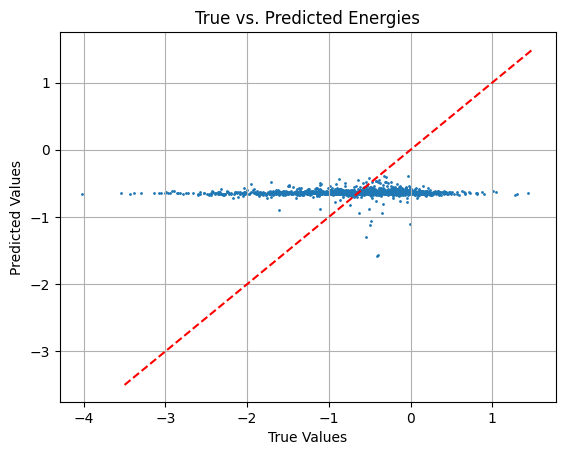

In [139]:
#Visualise


plt.scatter(y_test, predictions, s=1)
xg=[-3.5, 1.5]
plt.plot(xg, xg, color='red', linestyle='--')  # Ideal prediction line
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Energies")
plt.grid()
plt.show()
